![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://github.com/PracticumAI/deep_learning/blob/main/images/practicumai_deep_learning.png?raw=true' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>
***

# Understanding Computer Vision Tasks

Now that Kevin has a better understanding of how computer vision classification works, he needs to learn more about other computer vision tasks. His manager has asked him to move on from wasps and bees to... fruits and (bounding) boxes! Kevin thankfully has an annotated dataset already, so he can start learning about object detection.

As before, the dataset was found on Kaggle. [Check out the dataset information](https://www.kaggle.com/datasets/lakshaytyagi01/fruit-detection/data)

<img src="images/fruits_detection_dataset-cover.jpg" 
        alt="Image of fruits and bounding boxes from the dataset cover image" 
        width="1000" 
        height="600" 
        style="display: block; margin: 0 auto" />

## PyTorch

This notebook will be a bit different than the previous ones: it doesn't use TensorFlow or Keras. Instead, it uses PyTorch, torchvision, and YOLOv8. Whereas TensorFlow and Keras are easier to use for a variety of deep learning tasks (such as image classification), when it comes to object detection, PyTorch is currently more popular and better suited. YOLOv8 (You Only Look Once, version 8) is a popular object detection model that is known for its speed, accuracy, and relative ease of implementation.

As we've mentioned before, these tools are rapidly evolving, so it's important to stay up-to-date with the latest versions and best practices.



## 1.  Import the libraries we will use

In [6]:
# This notebook will be used for an Object Detection task that trains a model on the fruits_detection dataset using YOLOv8

# Importing the necessary libraries
import os
import sys
import json
import random
import pathlib
import requests
import zipfile
import time

import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from PIL import Image
import numpy as np
import pandas as pd
import torch
import yaml 
from ultralytics import YOLO
from ultralytics import settings

import helpers_02

import matplotlib.pyplot as plt
%matplotlib inline


Training on cuda


In [ ]:
# Print Pytorch versions and check for GPU
print(f'Pytorch version: {torch.__version__}')
print(f'  Should be "True" if Pytorch was built for GPU: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'  Available GPU: {torch.cuda.get_device_name()}')
else:
    print('  No GPU available, will use CPU')

# Set the number of workers for data loading
num_workers = None  # To manually set the number of workers, change this to an integer

if num_workers is None:
    # If Slurm is being used, set the number of workers to a Slurm-provided value.
    # If Slurm is not being used, set the number of workers to the number of available CPU cores.
    if os.getenv("SLURM_CPUS_PER_TASK") is not None:
        num_workers = int(os.getenv("SLURM_CPUS_PER_TASK"))
    elif os.getenv("SLURM_NTASKS_PER_NODE") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS_PER_NODE"))
    elif os.getenv("SLURM_NTASKS") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS"))
    else:
        num_workers = os.cpu_count()

print(f"Using {num_workers} workers for data loading.")

## 2. Getting the data

As we did in Notebook 1, we will have to find or download the dataset. This time the file is stored as a zip file, so we will need to extract it. 

You will also notice that instead of placing the downloaded data in the **data** directory, the data is instead loaded to a new folder called **datasets**. This is a requirement of YOLOv8, which expects the data to be in a specific folder. The setting is *technically* possible to change, but is not something we want to hassle with right now.

In [7]:
# Similar to the helpers_01 functions in the previous notebooks,
# The helpers_02.manage_data() function will check for and, if needed,
# download the dataset.
data_path = helpers_02.manage_data()

Found data at data/fruits_detection.


In [8]:
# Manage YOLO settings to set correct path to data folder
settings.update({"datasets_dir": data_path})

## 3. Explore the dataset

We will take a look at the dataset to see what it contains. We will also look at the annotations file, which contains the bounding box information for each image.

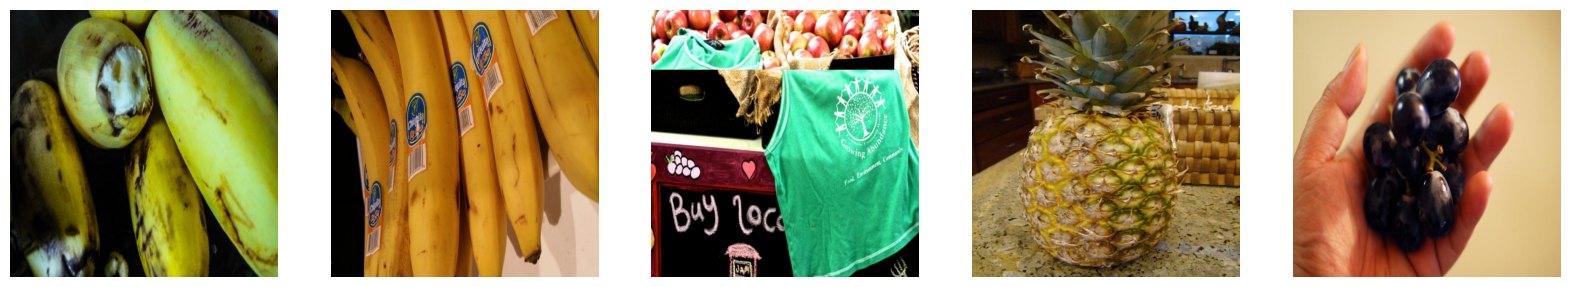

File: data/fruits_detection/train/labels/e0feba40525b0ecf_jpg.rf.a27a9c5a1a332da803f3c7c37adc51fa.txt
  1 0.50546875 0.725 0.821875 0.343359375
  2 0.29765625 0.30625 0.31484375 0.25625
  2 0.71015625 0.346875 0.3015625 0.23046875
File: data/fruits_detection/train/labels/8c7d69610416a787_jpg.rf.f1714aea0837d0bef977209c202bc745.txt
  3 0.1765625 0.36015625 0.353125 0.7203125
  3 0.6390625 0.5625 0.641015625 0.681640625
File: data/fruits_detection/train/labels/bc99461ea35344f3_jpg.rf.317dc1adc69f9a60a79279f2dc7aa2f8.txt
  2 0.221875 0.6859375 0.037890625 0.05234375
  2 0.2296875 0.634375 0.04140625 0.05078125
  2 0.31015625 0.971875 0.04375 0.053515625
  2 0.321875 0.7453125 0.028125 0.0484375
  2 0.33046875 0.9078125 0.0359375 0.040234375
File: data/fruits_detection/train/labels/05d91f69787c2df5_jpg.rf.0ddc9ab9e6c1983f35c85ef214ed37f9.txt
  0 0.60625 0.30390625 0.15 0.223828125
  0 0.49921875 0.49921875 0.9984375 0.9984375
  0 0.96640625 0.85 0.064453125 0.23671875
File: data/fruits_det

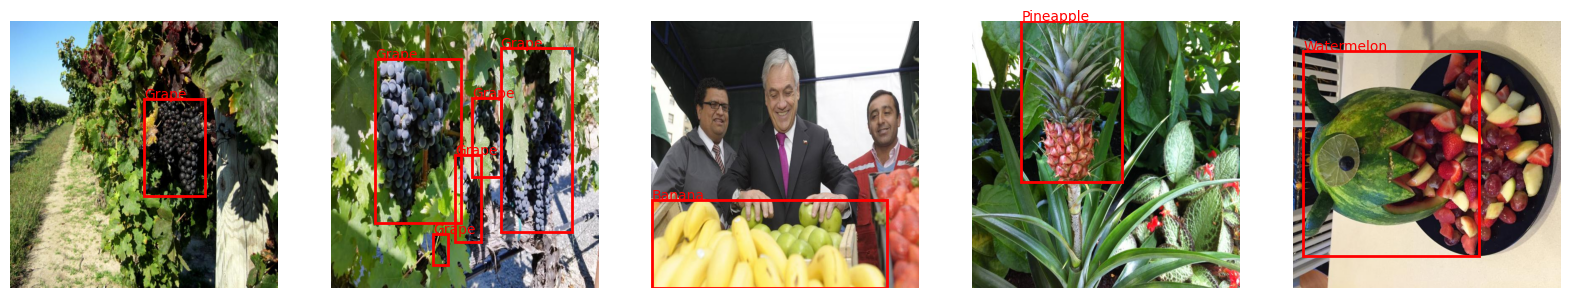

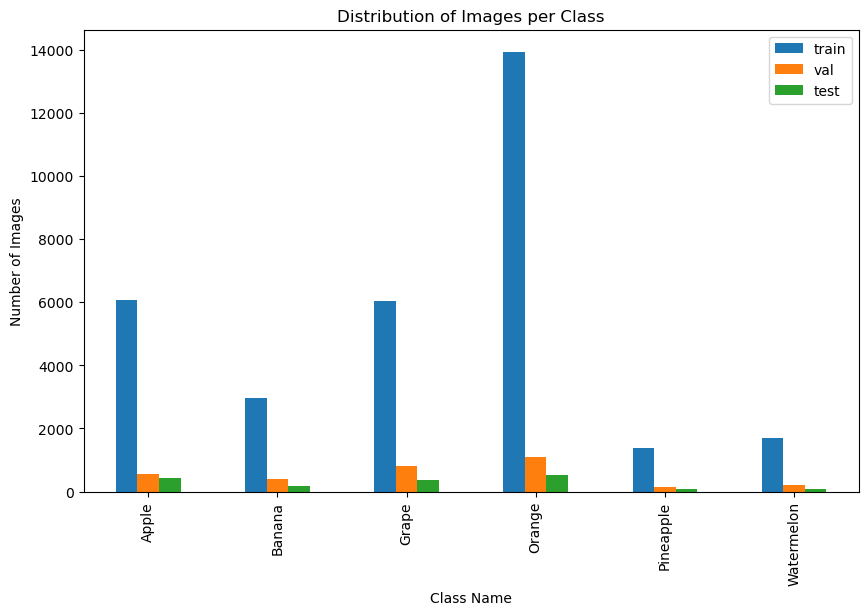

In [9]:
# Make a histogram of the number of images in each class
def explore_data(data_path, show_picture=True, show_annotation=True, show_detection=True, show_hist=True):

    # Define the class names
    class_names = ['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon']
    
    # Examine some sample images
    if show_picture:
        # Get valid image folders 
        image_folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))] 

        sample_images = []
        for i in range(5):
            folder = random.choice(image_folders) 
            img_path = os.path.join(data_path, folder, 'images', random.choice(os.listdir(os.path.join(data_path, folder, 'images'))))
            sample_images.append(img_path)

        # Plot the sample images
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        for i, img_path in enumerate(sample_images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
        plt.show()

    # Examine the first five annotation files
    if show_annotation:
        annotation_files = []
        for folder in os.listdir(data_path):
            if os.path.isdir(os.path.join(data_path, folder)):
                annotation_folder = os.path.join(data_path, folder, 'labels')
                if os.path.exists(annotation_folder):
                    for file in os.listdir(annotation_folder):
                        annotation_files.append(os.path.join(annotation_folder, file))
        for file in annotation_files[:5]:
            with open(file, 'r') as f:
                print(f"File: {file}")
                for i, line in enumerate(f):
                    if i > 4:
                        break
                    print(f"  {line.strip()}")

    # Plot five random images with their associated, labeled bounding boxes
    if show_detection:
        # Get valid image folders 
        image_folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))] 

        sample_images = []
        for i in range(5):
            folder = random.choice(image_folders) 
            img_path = os.path.join(data_path, folder, 'images', random.choice(os.listdir(os.path.join(data_path, folder, 'images'))))
            annotation_path = os.path.join(data_path, folder, 'labels', os.path.basename(img_path).replace('.jpg', '.txt'))
            sample_images.append((img_path, annotation_path))

        # Plot the sample images
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        for i, (img_path, annotation_path) in enumerate(sample_images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            with open(annotation_path, 'r') as f:
                for line in f:
                    class_id, x, y, w, h = map(float, line.strip().split())
                    x, y, w, h = x * img.width, y * img.height, w * img.width, h * img.height
                    rect = plt.Rectangle((x - w / 2, y - h / 2), w, h, fill=False, color='red', linewidth=2)
                    axes[i].add_patch(rect)
                    # Add class name above the bounding box
                    axes[i].text(x - w / 2, y - h / 2, class_names[int(class_id)], color='red')
        plt.show()


    # Make a histogram of the number of images in each class
    if show_hist:
        def get_class_counts(folder_path):  # Change from data_path to folder_path
            class_counts = {}
            labels_path = os.path.join(folder_path, 'labels')  # Add labels path
            for filename in os.listdir(labels_path):  # Update listdir
                with open(os.path.join(labels_path, filename), 'r') as f:
                    for line in f:
                        class_id = int(line.split(' ')[0])  # Assuming labels are in YOLO format
                        class_counts[class_id] = class_counts.get(class_id, 0) + 1
            return class_counts

        train_counts = get_class_counts(os.path.join(data_path, 'train'))  # Add os.path.join
        val_counts = get_class_counts(os.path.join(data_path, 'valid'))
        test_counts = get_class_counts(os.path.join(data_path, 'test'))
        num_classes = len(class_names)

        data_counts = {
            'train': pd.Series(train_counts),
            'val': pd.Series(val_counts),
            'test': pd.Series(test_counts)
        }
        df = pd.DataFrame(data_counts)

        df.plot.bar(figsize=(10, 6))
        plt.xlabel('Class Name')
        plt.xticks(np.arange(num_classes), class_names)
        plt.ylabel('Number of Images')
        plt.title('Distribution of Images per Class')
        plt.legend()
        plt.show()

explore_data(data_path, show_picture=True, show_annotation=True, show_detection=True, show_hist=True)

There's a lot to unpack here! First, depending on the images sampled, we can see that the images are of different sizes and have different numbers of fruits. Other things to note:
- Some of the images don't really contain fruits...
- The annotations file names are the same as the image names, but with a .txt extension.
- The annotations file contains the class ID of the fruit (0 corresponds to 'Apple', etc.), and the bounding box coordinates. 
- The bounding box coordinates are in the format (x_min, y_min, x_max, y_max).
- The bounding box coordinates are normalized, meaning that they are scaled to be between 0 and 1. This is a common practice in object detection tasks.
- The bounding boxes in some of the images are not very accurate. This is a common problem in object detection tasks.
- The dataset is very imbalanced, with a lot more oranges than other fruits.

## 4. Create the YAML file
YAML stands for "YAML Ain't Markup Language" and is a human-readable data serialization format. A YAML file is used to define the dataset configuration for training a YOLOv8 model. YAML configuration files are popular in deep learning because they are relatively easy for humans to read and write, with the goal being to increase transparency and reproducibility.

In [10]:
# Create a YAML file for the YOLOv8 model configuration

def create_yaml(data_path, class_names, yaml_file='fruits_detection_data.yaml'):
    # Creates a YOLOv8 data.yaml file.
    
    yaml_dict = {
        # 'path': data_path,  # Path to your dataset
        'train': data_path + '/train/images',  # Relative path to training images
        'val': data_path + '/valid/images',    # Relative path to validation images
        'test': data_path + '/test/images',    # Relative path to testing images

        'num_classes': len(class_names),   # Number of classes
        'names': class_names      # List of class names
    }

    with open(yaml_file, 'w') as outfile:
        yaml.dump(yaml_dict, outfile, default_flow_style=False)

    print(f'YAML file created: {yaml_file}')


class_names = ['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon']

create_yaml(data_path, class_names) 

YAML file created: fruits_detection_data.yaml


## 5. Create and fit the model

We will create a YOLOv8 model and fit it to the data. YOLOv8 has a lot of hyperparameters that can be tuned, but we will use the default values for now. For more information on its hyperparameters, [check out the YOLOv8 documentation](https://docs.ultralytics.com/modes/train/).

Another neat feature of YOLOv8 is that by default it provides several evaluation metrics, such as the loss, precision, recall, and F1 score. This is very useful for monitoring the model's performance during training.

In [11]:
# Make the YOLOv8 model
model = YOLO('yolov8n.yaml')
results = model.train(data='fruits_detection_data.yaml', imgsz=640, epochs=10)

Ultralytics 8.3.157 🚀 Python-3.12.11 torch-2.7.1+cu128 CUDA:0 (NVIDIA B200, 182642MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fruits_detection_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretraine

100%|██████████| 5.35M/5.35M [00:00<00:00, 84.4MB/s]


WARNING ⚠️ NMS time limit 2.400s exceeded
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 103.7±37.2 MB/s, size: 50.5 KB)


train: Scanning /blue/ufhpc/magitz/PracticumAI/computer_vision/data/fruits_detection/train/labels... 7108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7108/7108 [00:03<00:00, 1793.83it/s]

train: /blue/ufhpc/magitz/PracticumAI/computer_vision/data/fruits_detection/train/images/3d8be4f881b8c54c_jpg.rf.0d7b6d095459cece040b47b246d807af.jpg: 1 duplicate labels removed
train: /blue/ufhpc/magitz/PracticumAI/computer_vision/data/fruits_detection/train/images/3d8be4f881b8c54c_jpg.rf.64e869a9bedd5f012cc2a1129c6ca229.jpg: 1 duplicate labels removed


train: New cache created: /blue/ufhpc/magitz/PracticumAI/computer_vision/data/fruits_detection/train/labels.cache


/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 111.4±33.7 MB/s, size: 59.8 KB)


val: Scanning /blue/ufhpc/magitz/PracticumAI/computer_vision/data/fruits_detection/valid/labels... 914 images, 0 backgrounds, 0 corrupt: 100%|██████████| 914/914 [00:00<00:00, 1775.09it/s]

val: /blue/ufhpc/magitz/PracticumAI/computer_vision/data/fruits_detection/valid/images/3d3ddc3054b32eb7_jpg.rf.03e7789aaf5212e2634b84ef502e0832.jpg: 1 duplicate labels removed
val: New cache created: /blue/ufhpc/magitz/PracticumAI/computer_vision/data/fruits_detection/valid/labels.cache



/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic


/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.52G      3.058      4.312      3.783          4        640: 100%|██████████| 445/445 [01:29<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:30<00:00,  1.04s/it]


                   all        914       3227    0.00407      0.306     0.0079    0.00296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.17G      2.239      3.575      2.755         32        640: 100%|██████████| 445/445 [00:44<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.22it/s]


                   all        914       3227      0.305     0.0911     0.0403       0.02

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.19G      1.838      3.101      2.286          9        640: 100%|██████████| 445/445 [00:43<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.04it/s]

                   all        914       3227      0.266      0.118     0.0552     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.19G      1.662      2.802       2.06          8        640: 100%|██████████| 445/445 [00:41<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  7.84it/s]

                   all        914       3227      0.135       0.15     0.0714      0.037



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.21G      1.542      2.585      1.949         21        640: 100%|██████████| 445/445 [00:41<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  7.59it/s]


                   all        914       3227      0.159      0.173     0.0905     0.0474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.21G      1.456      2.413      1.852          4        640: 100%|██████████| 445/445 [00:40<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  8.61it/s]


                   all        914       3227      0.219      0.177      0.118     0.0635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.21G      1.404      2.295      1.797         12        640: 100%|██████████| 445/445 [00:43<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  8.36it/s]


                   all        914       3227      0.228      0.201      0.127     0.0696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.21G      1.357      2.202      1.746         10        640: 100%|██████████| 445/445 [00:41<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  8.61it/s]


                   all        914       3227      0.243      0.205      0.143      0.078

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.21G      1.311      2.104      1.706          8        640: 100%|██████████| 445/445 [00:40<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  8.42it/s]


                   all        914       3227      0.261      0.207      0.154     0.0842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.21G      1.282      2.031      1.665         10        640: 100%|██████████| 445/445 [00:42<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  7.91it/s]

                   all        914       3227      0.294      0.219      0.171     0.0946



10 epochs completed in 0.150 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.157 🚀 Python-3.12.11 torch-2.7.1+cu128 CUDA:0 (NVIDIA B200, 182642MiB)
YOLOv8n summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.94it/s]


                   all        914       3227      0.294      0.221      0.171     0.0947
                 Apple        188        557      0.307      0.251      0.199      0.128
                Banana        167        390      0.363        0.2      0.185     0.0905
                 Grape        199        809      0.272      0.166      0.128     0.0549
                Orange        197       1100      0.298      0.373      0.276       0.16
             Pineapple         77        154      0.261      0.135      0.103      0.049
            Watermelon        107        217      0.266      0.201      0.131     0.0853
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


## 6. Evaluate the results

Let's look at those evaluation metrics we mentioned above. YOLOv8 creates a **runs** folder that stores each training run. We'll pull them up here and examine what they mean.

In [12]:
# Plot the evaluation results

# Find the latest training run
training = sorted(os.listdir('runs/detect/.'))
latest_training = training[-1]
print(f'Latest training run: {latest_training}')

# Plot the .png files in the latest training run
for file in os.listdir(f'runs/detect/{latest_training}'):
    if file.endswith('.png'):
        # Exclude the normalized confusion matrix since it's redundant
        if 'normalized' in file:
            continue
        img = Image.open(f'runs/detect/{latest_training}/{file}')
        plt.imshow(img)
        plt.axis('off')
        plt.show()

Latest training run: train8


## Breaking down the graphs

If your stats are a little rusty like Kevin's, you might need a bit of refresher to make sense of the graphs above. Expand the section below for explanations of the terms used above.

<details>
    
<summary>Click to expand for stats terms!</summary>

<p>

##### What is Precision?
Precision is the ratio of correctly predicted positive observations to the total predicted positives. An example in our fruit object detection task would be the ratio of correctly predicted apples to the total predicted apples. Higher precision values are better, as they indicate that the model is making more accurate predictions.

##### What is Recall?
Recall is the ratio of correctly predicted positive observations to the true number of observations of a class. An example in our fruit object detection task would be the ratio of correctly predicted apples to the total actual apples. Higher recall values are better, as they indicate that the model is making more accurate predictions.

##### What is Confidence?
Confidence is the probability that a model assigns to a prediction. In our fruit object detection task, the confidence is the probability that a model assigns to a fruit being an apple, orange, or any other fruit. Higher confidence values are better, as they indicate that the model is more certain about its predictions.

##### What is a confusion matrix?
A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm. The confusion matrix shows the ways in which your classification model is confused when it makes predictions. It gives you insight not only into the errors being made by your classifier but more importantly the types of errors that are being made.

##### What is the F1 Confidence Curve?
The F1 Confidence Curve is a plot of the F1 score against the confidence threshold. The F1 score is the harmonic mean of precision and recall, and it is a measure of a model's accuracy. The confidence threshold is the minimum confidence level that a model must have in order to make a prediction. The F1 Confidence Curve is used to determine the optimal confidence threshold for a model. The curve shows how the F1 score changes as the confidence threshold is varied. The goal is to find the confidence threshold that maximizes the F1 score. The highest point on the curve tells you the optimal confidence threshold where the model strikes the best balance between precision and recall. In our fruit object detection task, the F1 Confidence Curve would show how the F1 score changes as the confidence threshold is varied for each fruit class. Higher F1 scores are better, as they indicate that the model is making more accurate predictions.
    
##### What is mAP50?
mAP50 stands for "mean Average Precision at 50% confidence". It is a common metric used in object detection tasks to evaluate the performance of a model. The mAP50 is the average of the precision values at different recall levels, where the recall is calculated at a confidence threshold of 50%. A higher mAP50 value indicates better performance.
    
##### What is mAP50-95?
mAP50-95 is the mean average precision (mAP) over the range of intersection over union (IoU) thresholds from 0.5 to 0.95. IoU is a measure of the overlap between two bounding boxes. It is calculated as the area of the intersection of the two bounding boxes divided by the area of their union. An IoU of 0 means that the two bounding boxes do not overlap at all, while an IoU of 1 means that the two bounding boxes are identical. The mAP50-95 metric is a more comprehensive metric than the mAP50 metric, which only considers the IoU threshold of 0.5. The mAP50-95 metric provides a more complete picture of the model's performance across a range of IoU thresholds.

</p>
</details>

In addition to those graphs, we can look at the predictions themselves. 

In [ ]:
# Plot the labels and predictions from the last training run

# Load the images
img1 = Image.open(f'runs/detect/{latest_training}/val_batch0_labels.jpg')
img2 = Image.open(f'runs/detect/{latest_training}/val_batch0_pred.jpg')

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Ground Truth')
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Predictions')
plt.show()


From the prediction images, you'll probably notice this model loves its citrus. That's no surprise given the histogram we looked at at the beginning of this notebook. What could we do to improve this?

## 7. Inference
How does the model fare on some test images? After you run the cell below:
1. Find your own image of fruit.
2. Upload it to this folder.
3. Add or edit the code below to run on the new image rather than images in the test folder.


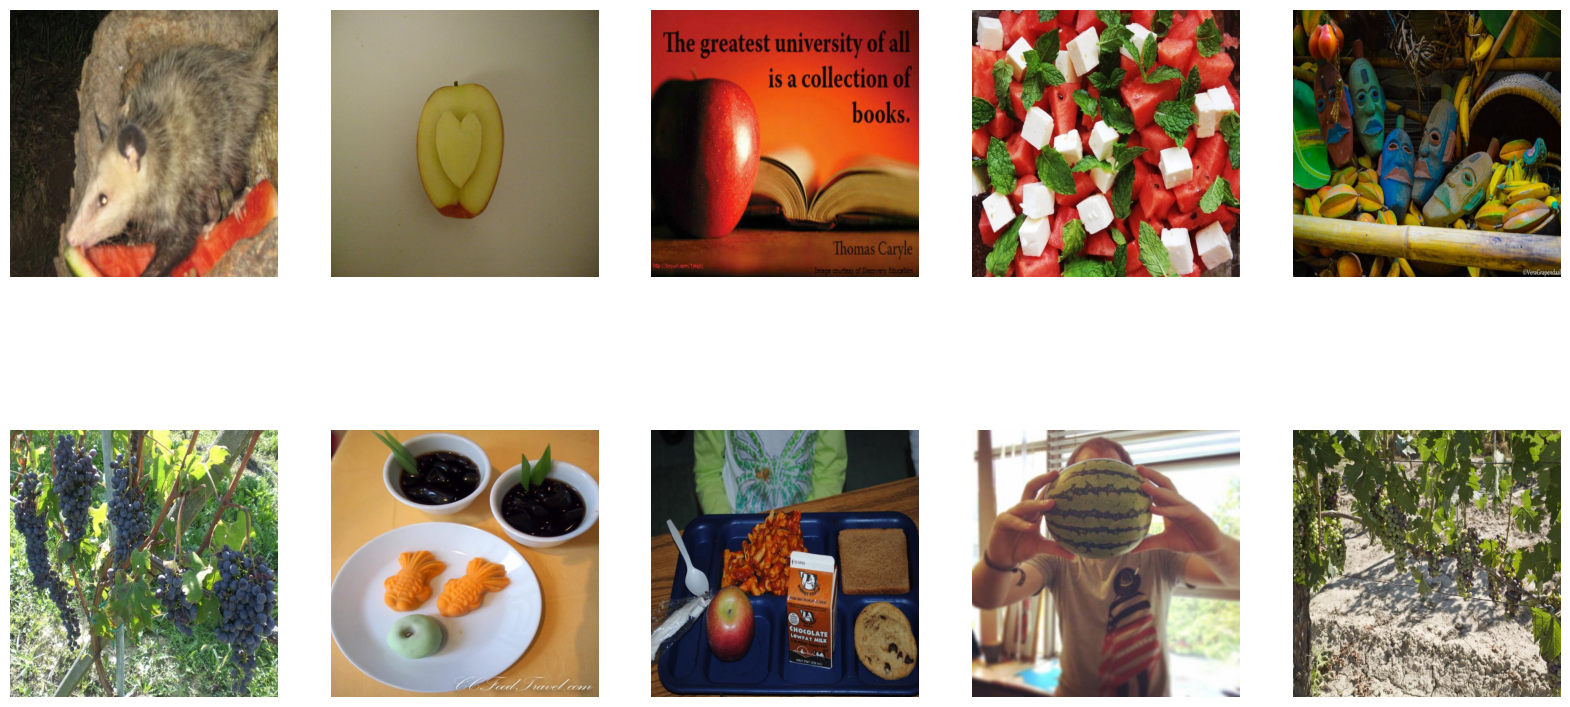


0: 640x640 1 Orange, 186.4ms
1: 640x640 1 Apple, 186.4ms
2: 640x640 (no detections), 186.4ms
3: 640x640 1 Grape, 186.4ms
4: 640x640 (no detections), 186.4ms
5: 640x640 5 Grapes, 186.4ms
6: 640x640 1 Orange, 186.4ms
7: 640x640 3 Oranges, 186.4ms
8: 640x640 (no detections), 186.4ms
9: 640x640 (no detections), 186.4ms
Speed: 52.5ms preprocess, 186.4ms inference, 19.4ms postprocess per image at shape (1, 3, 640, 640)


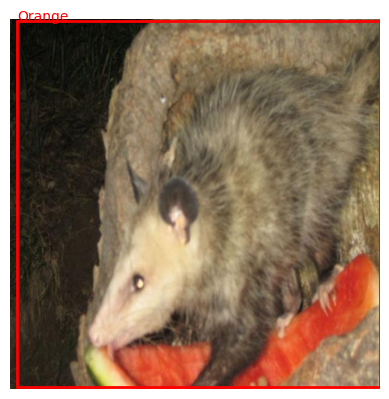

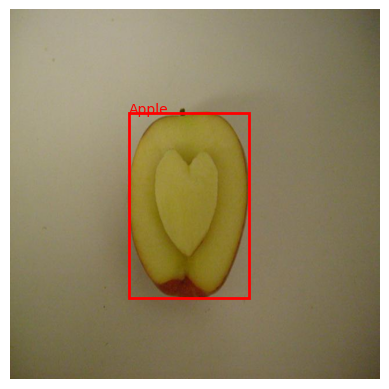

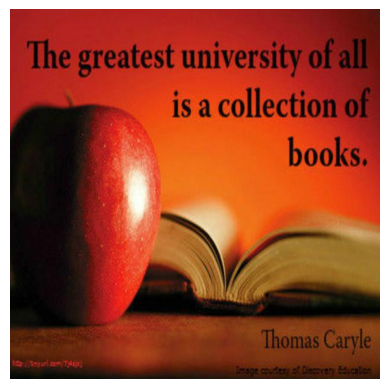

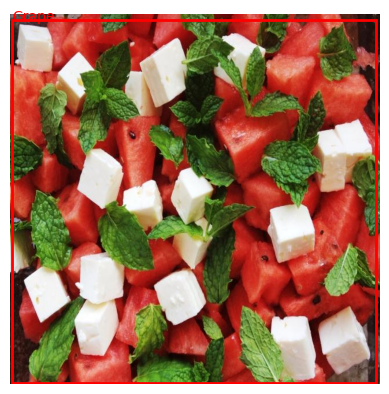

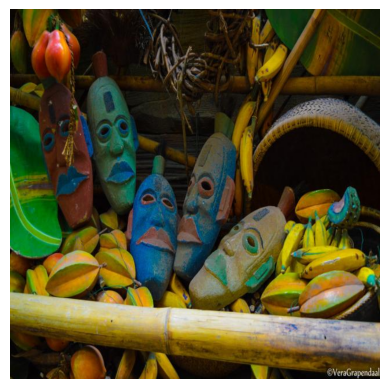

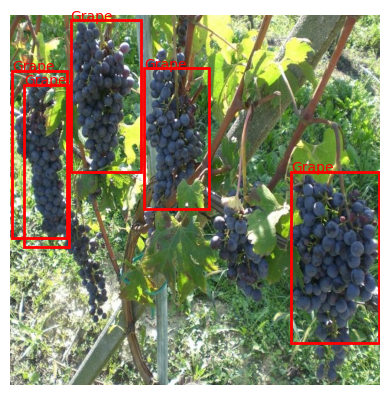

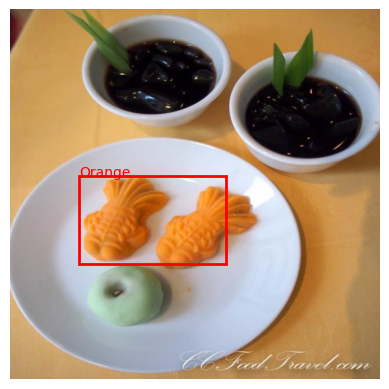

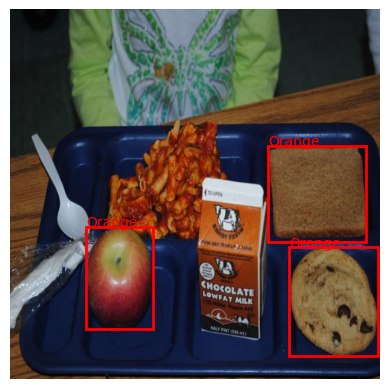

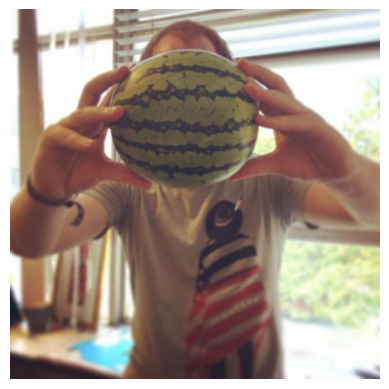

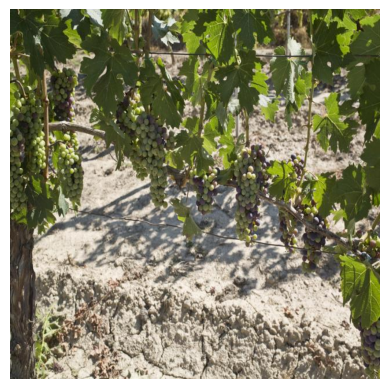

In [13]:
# Run the model on a few test images

# Get ten random test images
test_images = []
for folder in os.listdir(os.path.join(data_path, 'test', 'images')):
    img_path = os.path.join(data_path, 'test', 'images', folder)
    test_images.append(img_path)
test_images = random.sample(test_images, 10)

# Plot the test images
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, img_path in enumerate(test_images):
    img = Image.open(img_path)
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
plt.show()

# Run the model on the test images
infer_results = model.predict(test_images)

for img_path, result in zip(test_images, infer_results):
    img = Image.open(img_path)
    img = img.resize((640, 640))

    # Create the plot for this image
    plt.imshow(img)
    plt.axis('off')

    # Access bounding boxes and class information
    boxes = result.boxes
    class_ids = boxes.cls.cpu().numpy()  # Class IDs are on the CPU
    confidences = boxes.conf.cpu().numpy()  # Confidences are on the CPU

    for box, class_id, conf in zip(boxes.xyxy, class_ids, confidences):  
        # boxes.xyxy are in [xmin, ymin, xmax, ymax] format
        x1, y1, x2, y2 = box.cpu()  # Move coordinates to CPU
        w, h = x2 - x1, y2 - y1
        rect = plt.Rectangle((x1, y1), w, h, fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x1, y1, result.names[int(class_id)], color='red')  

    # Display the plot
    plt.show()

## 8. Explore hyperparameters

Now that you have a good baseline, consider how you might deal with this model's issues.
- How would you address issues in the dataset?
- How would you optimize training?

A good first place to start would be YOLOv8's documentation so you can understand what hyperparameters you have access to and how changing them will affect training. Make some adjustments and see how high you can get your fruits object detection F1 score!

## Bonus Exercises

- You might have noticed the *yolov8n.pt* file that is added to the folder when you load YOLO. That is the pre-trained model using the [COCO dataset](https://cocodataset.org/#home). The YOLOv8 documentation linked above provides instructions for transfer learning and fine-tuning with the pre-trained model. Give it a shot!

- If you're feeling very bold and want the full Object Detection Experience, find an image labeler and build your own dataset! If you use proprietary data, be sure that the software you use to label meets your institution's guidelines for data sharing. If you go this route, you will almost certainly want to use the fine-tuning option mentioned above, otherwise you're going to be spending quite a long time labeling...